## Import Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential, Model
import json
from datetime import datetime
from keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import Callback
import time
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

2025-04-03 18:18:03.098240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743718683.116232   27317 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743718683.121702   27317 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743718683.137355   27317 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743718683.137378   27317 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743718683.137380   27317 computation_placer.cc:177] computation placer alr

# Enable GPU

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         print(e)

## Load the Dataset

In [3]:
# Define image paths
clean_path = "/home/yehia/celaba_datasets/celeba_128x128_10000/clean"
noisy_path = "/home/yehia/celaba_datasets/celeba_128x128_10000/noisy"

# Load all image filenames
image_filenames = sorted(os.listdir(clean_path))

# Load images
clean_images = []
noisy_images = []

for fname in image_filenames:
    clean_img = Image.open(os.path.join(clean_path, fname)).convert('RGB')
    noisy_img = Image.open(os.path.join(noisy_path, fname)).convert('RGB')
    
    clean_images.append(np.array(clean_img))
    noisy_images.append(np.array(noisy_img))

# Convert lists to numpy arrays
clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

# Split into training and testing sets
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    clean_images, noisy_images, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

# Shuffle data while maintaining alignment
perm = np.random.permutation(len(x_train_clean))
x_train_clean = x_train_clean[perm]
x_train_noisy = x_train_noisy[perm]

perm_test = np.random.permutation(len(x_test_clean))
x_test_clean = x_test_clean[perm_test]
x_test_noisy = x_test_noisy[perm_test]


## Exploratory Data Analysis

### Dataset Size

In [4]:
print(f"Number of training images: {x_train_clean.shape[0]}")
print(f"Number of test images: {x_test_clean.shape[0]}")

Number of training images: 9000
Number of test images: 1000


### Distribution and Value Ranges

In [5]:
print("Image shape (train):", x_train_clean[0].shape)
print("Pixel value range (clean):", x_train_clean.min(), "to", x_train_clean.max())
print("Pixel value range (noisy):", x_train_noisy.min(), "to", x_train_noisy.max())

Image shape (train): (128, 128, 3)
Pixel value range (clean): 0.0 to 1.0
Pixel value range (noisy): 0.0 to 1.0


### Pixel Intensity Distributions

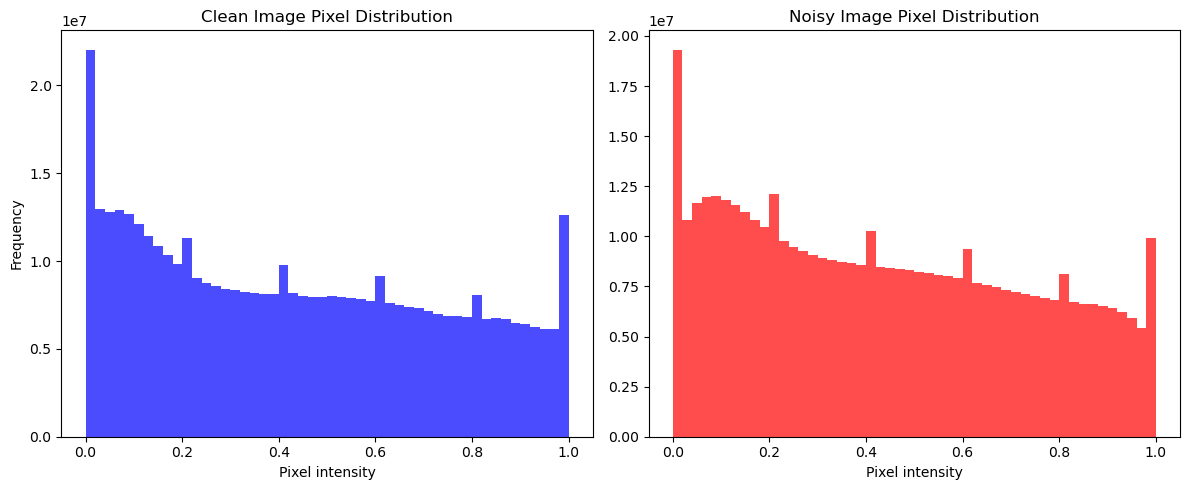

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x_train_clean.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Clean Image Pixel Distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(x_train_noisy.flatten(), bins=50, color='red', alpha=0.7)
plt.title("Noisy Image Pixel Distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()

### Visualize Images

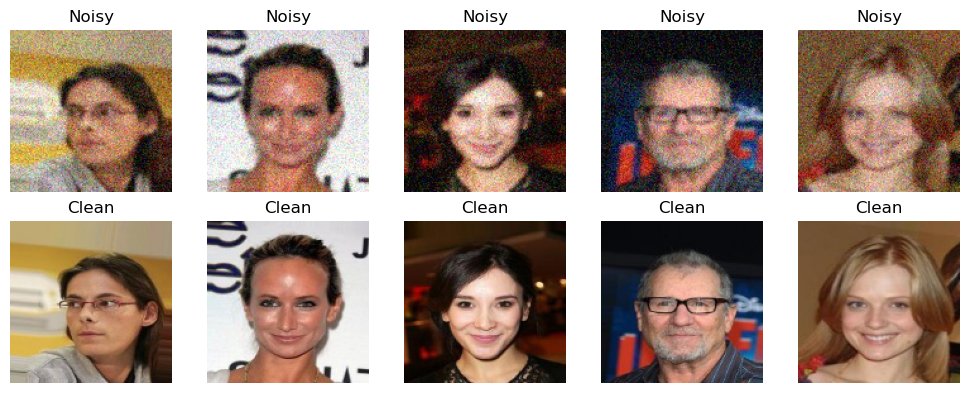

In [7]:
def show_samples(clean, noisy, num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Noisy
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')
        
        # Clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(x_train_clean, x_train_noisy)

## Model Creation

In [8]:
epochs = 200
batch_size = 16
alpha = 0.84
loss_function = "ssim_mse"
model_name = f"UDnCNN_{loss_function}_a{alpha}_e{epochs}_b{batch_size}_v1"
print(model_name)

UDnCNN_ssim_mse_a0.84_e200_b16_v1


### SSIM Loss function

In [9]:
def combined_loss_mae(y_true, y_pred, alpha=alpha):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * mae + (1 - alpha) * (1 - ssim)

def combined_loss_mse(y_true, y_pred, alpha=alpha):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return alpha * mse + (1 - alpha) * (1 - ssim)

In [10]:
input_img = Input(shape=(x_train_clean.shape[1], x_train_clean.shape[2], x_train_clean.shape[3]))

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, output])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss=combined_loss_mse)
# model.summary()

I0000 00:00:1743718715.502727   27317 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5557 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


## Train the model

### Callback to Track Time

In [11]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()  # returns float in seconds

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time

time_callback = TimeHistory()

### Train

In [12]:
history = model.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_test_noisy, x_test_clean),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[time_callback]
)
print("Training time (seconds):", round(time_callback.total_time, 2))

2025-04-03 18:18:36.854267: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1769472000 exceeds 10% of free system memory.
2025-04-03 18:18:37.837579: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1769472000 exceeds 10% of free system memory.
2025-04-03 18:18:38.528131: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1769472000 exceeds 10% of free system memory.
2025-04-03 18:18:38.953361: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 1/200


I0000 00:00:1743718722.656387   27379 service.cc:152] XLA service 0x7f1b0004b8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743718722.656432   27379 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-04-03 18:18:42.830574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-03 18:18:43.092554: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
2025-04-03 18:18:43.092727: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
2025-04-03 18:18:43.093318: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
2025-04-03 18:18:43.093501: W tensorf

  1/563 ━━━━━━━━━━━━━━━━━━━━ 1:25:32 9s/step - loss: 1.3865

I0000 00:00:1743718728.592256   27379 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1191

2025-04-03 18:19:05.650403: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
2025-04-03 18:19:05.650466: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
2025-04-03 18:19:05.650518: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
2025-04-03 18:19:05.650539: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_3/Assert


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1189

2025-04-03 18:19:11.246384: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
2025-04-03 18:19:11.246535: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
2025-04-03 18:19:11.247352: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_2/Assert
2025-04-03 18:19:11.247517: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_3/Assert
2025-04-03 18:19:12.476592: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert/Assert
2025-04-03 18:19:12.476654: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/combined_loss_mse/SSIM/Assert_1/Assert
2025-04-03 18:19:12.476719: W tensorflow/compiler/

563/563 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - loss: 0.1188 - val_loss: 0.0395
Epoch 2/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0383 - val_loss: 0.0413
Epoch 3/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0351 - val_loss: 0.0350
Epoch 4/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0330 - val_loss: 0.0333
Epoch 5/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0322 - val_loss: 0.0311
Epoch 6/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0311 - val_loss: 0.0310
Epoch 7/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0300 - val_loss: 0.0294
Epoch 8/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0290 - val_loss: 0.0283
Epoch 9/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 0.0282 - val_loss: 0.0276
Epoch 10/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0280 - val_loss: 0.0275
Epoch 11/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0269 - val_loss: 0.0287
Epoch 12/200
563/563 ━━━━━━━━━━

### Save

In [13]:
model_dir = f"./models/{model_name}"
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "model.keras"))
print(f"\n✅ Model saved to: {model_dir}")


✅ Model saved to: ./models/UDnCNN_ssim_mse_a0.84_e200_b16_v1


## Evaluate the Model

### Predict

In [14]:
predictions = model.predict(x_test_noisy)

2025-04-03 19:09:11.758784: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bias-activation.26 = (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,128,128]{3,2,1,0} %bitcast.618, f32[64,3,3,3]{3,2,1,0} %bitcast.625, f32[64]{0} %bitcast.627), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/yehia/anaconda3/envs/tf310_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-04-03 19:09:11.763093: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 3.592328615s
Try

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


### Evaluate

In [15]:
mae = np.mean(np.abs(predictions - x_test_clean))
mse = np.mean((predictions - x_test_clean) ** 2)

psnr_total, ssim_total = 0, 0
for i in range(len(x_test_clean)):
    psnr_total += peak_signal_noise_ratio(x_test_clean[i], predictions[i], data_range=1.0)
    ssim_total += structural_similarity(x_test_clean[i], predictions[i], channel_axis=-1, data_range=1.0)

psnr_avg = psnr_total / len(x_test_clean)
ssim_avg = ssim_total / len(x_test_clean)

### Save Metadata

In [16]:
metadata = {
    "model_name": model_name,
    "created_at": datetime.now().isoformat(),
    "loss_function": loss_function,
    "alpha": alpha,
    "epochs": int(epochs),
    "batch_size": int(batch_size),
    "training_time_seconds": round(float(time_callback.total_time), 2),
    "dataset_info": {
        "train_size": int(x_train_clean.shape[0]),
        "test_size": int(x_test_clean.shape[0]),
        "image_shape": list(map(int, x_train_clean.shape[1:]))
    },
    "evaluation_metrics": {
        "mae": round(float(mae), 6),
        "mse": round(float(mse), 6),
        "psnr_avg": round(float(psnr_avg), 3),
        "ssim_avg": round(float(ssim_avg), 3)
    }
}
with open(os.path.join(model_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {model_dir}")


✅ Metadata saved to: ./models/UDnCNN_ssim_mse_a0.84_e200_b16_v1


### Visualize the Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013063788..1.0753286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007861037..1.0455071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025218926..1.0303398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05208686..1.0105007].


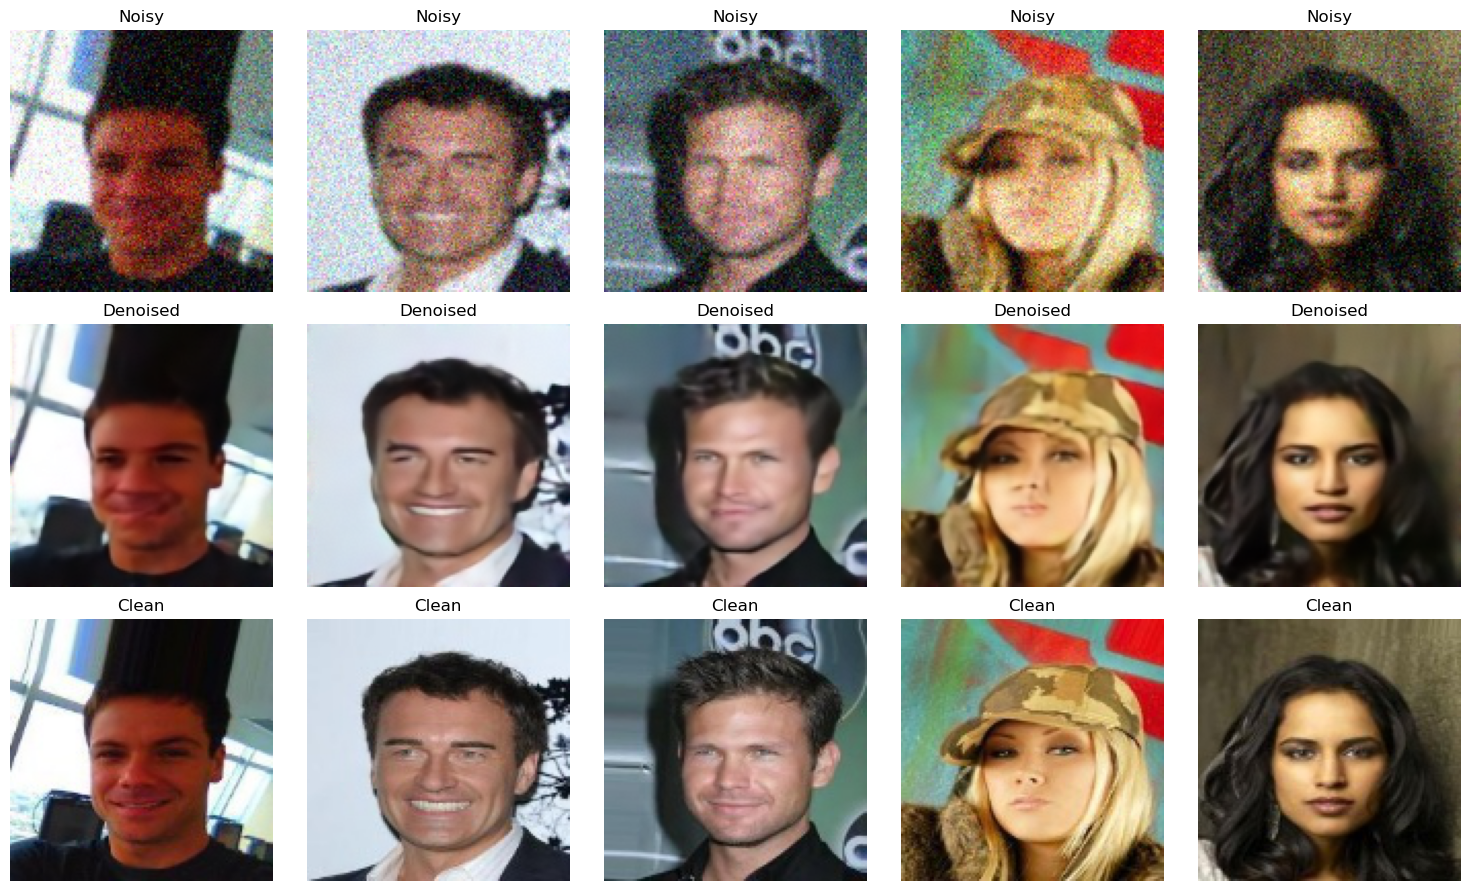

In [17]:
def show_predictions(noisy, clean, predicted, num_images=5):
    plt.figure(figsize=(num_images * 3, 9))
    for i in range(num_images):
        # Noisy
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Predicted
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(x_test_noisy, x_test_clean, predictions)

In [18]:
def visualize_and_save_denoising(noisy, predicted, clean, model_dir, num_images=5):
    """
    Visualize and save a comparison of noisy, denoised, and clean images.
    
    Args:
        noisy (numpy array): Noisy input images
        predicted (numpy array): Model predictions (denoised images)
        clean (numpy array): Ground truth clean images
        model_dir (str): Directory where the visualization image will be saved
        num_images (int): Number of image samples to visualize
    """
    plt.figure(figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Noisy input
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised (model output)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Ground truth
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(model_dir, "denoising_visualization.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"📸 Visualization saved to: {save_path}")

visualize_and_save_denoising(
    noisy=x_test_noisy,
    predicted=predictions,
    clean=x_test_clean,
    model_dir=model_dir,
    num_images=5  # You can increase this number if desired
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013063788..1.0753286].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007861037..1.0455071].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025218926..1.0303398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05208686..1.0105007].


📸 Visualization saved to: ./models/UDnCNN_ssim_mse_a0.84_e200_b16_v1/denoising_visualization.png
